
# Objective of the Notebook


In this Notebook we will be creating a model to identify whether a patient is having Pneumonia from the X-Ray image of their chest. In the medical science field, doctors need to diagnose if the patient is having pneumonia, and the X-Ray image is one of the major form of reference for the same. If with the help of Data Science, we shall be able to create a model that actually helps them to spot out the cases, then we will be helping them out with faster diagnosis of the illness.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau
import cv2
import os

# Importing the necessary libraries

In [3]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

# Loading the Dataset

In [4]:
train = get_training_data('D:/SCIT/Sem4/Healthcare Analytics/chest_xray/chest_xray/train')
test = get_training_data('D:/SCIT/Sem4/Healthcare Analytics/chest_xray/chest_xray/test')
val = get_training_data('D:/SCIT/Sem4/Healthcare Analytics/chest_xray/chest_xray/val')

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



<ipython-input-3-b2613b36a4a4>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4062: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'



Now that we have ingested the data into three variables- Train, Test and Validation Set. Now we shall be able to work succesfully with the total data. Lets take a look into the development that follows

# Data Visualization & Preprocessing

Let us try to see how well is the data distributed. Since we are working on a classification problem, if our data labels are not likewse distributed- the results will be highly biased too. This would not be something we want. Let us take a look into the data that we are using right now.

C:\Users\Garima Rawat\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

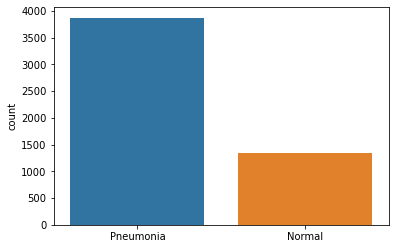

In [5]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
    else:
        l.append("Normal")
sns.countplot(l) 

**Observation** Clearly, the data seems to be imbalanced in this case. Now in order to balance the distribution of the training examples, we would be using data augmentation procedure.
In order to read more about Data Augmentation, please read the following article: https://www.tensorflow.org/tutorials/images/data_augmentation

Before actually doing that, let us just take a look at a sample each of each class.

Text(0.5, 1.0, 'NORMAL')

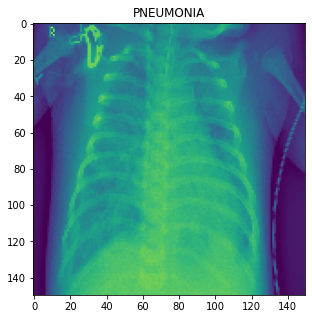

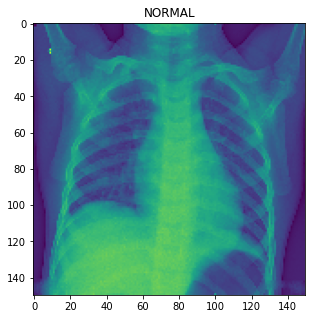

In [6]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='viridis')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='viridis')
plt.title(labels[train[-1][1]])

**Fact** An x-ray exam allows a doctor to see your lungs, heart and blood vessels to help determine if you have pneumonia. When interpreting the x-ray, the radiologist will look for white spots in the lungs (called infiltrates) that identify an infection. This exam will also help determine if you have any complications related to pneumonia such as abscesses or pleural effusions (fluid surrounding the lungs).

Now obviously, as I am no doctor, I wont't be able to identify the ailment just by looking at the X-Ray. So I will just be creating a model to solve the problem.

Now based on the data we have ingested, its time to distribute them into the respective training, testing and validation groups. And using these values we will be implementing our model

In [7]:
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

x_val = []
y_val = []    

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

x_test = []
y_test = []    
    
for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

# Image Normalization

Now in the images that we have, there might be instances where the range of illumination is too huge for processing. Like any other model, if a normalization factor is introduced, the model's ability to interpret the data becomes much better.

Likewise, a Convolution Neural Network will be much more efficient when the data is normalized.

In [8]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [9]:
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data Augmentation

In [10]:
data_generator = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


data_generator.fit(x_train)

For the data augmentation, I selected the following techniques :

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 10% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally. 

Once our model is ready, we will fit the training dataset.

# Training the Model

As discussed previously, we shall be working on the creation of a multilayer Convolution Neural Network, which will be responsible to parse through the images and provide us with an estimation if the image we are seeing is that of an infected patient or a normal patient.

Just to make it fun;

![](https://analyticsindiamag.com/wp-content/uploads/2018/01/conv-full-layer.gif)

### Creating the Neural Network Model

In [11]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))

model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

We can see the model structure built above.

Now we will start fitting out data into the model to estimate its accuracy. Initially, We are choosing 10 epochs for seeing the overall result. Lets find out the level of accuracy we reach.

## Fitting the Model

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
history = model.fit(data_generator.flow(x_train,y_train, batch_size = 32) ,epochs = 10 , validation_data = data_generator.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/10
163/163 [==============================] - 154s 926ms/step - loss: 0.4687 - accuracy: 0.8441 - val_loss: 51.1331 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/10
163/163 [==============================] - 145s 887ms/step - loss: 0.2366 - accuracy: 0.9174 - val_loss: 78.2854 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/10
163/163 [==============================] - ETA: 0s - loss: 0.1882 - accuracy: 0.9241
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 141s 864ms/step - loss: 0.1882 - accuracy: 0.9241 - val_loss: 63.5595 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/10
163/163 [==============================] - 142s 869ms/step - loss: 0.1237 - accuracy: 0.9571 - val_loss: 7.6475 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/10
163/163 [==============================] - 138s 847ms/step - loss: 0.1149 - accuracy: 0.9578 - val_loss: 0.6092 - val_accuracy: 0.7500 - lr: 3.0000e-04
Epoch 6/10
163/163 [=============

# Checking the Results on the Test Data

In [13]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 [==============================] - 4s 193ms/step - loss: 0.4843 - accuracy: 0.9119
Loss of the model is -  0.48431748151779175
20/20 [==============================] - 4s 197ms/step - loss: 0.4843 - accuracy: 0.9119
Accuracy of the model is -  91.18589758872986 %


**Observations:** 90%+ Accuracy! 


# Analysis after Model Training

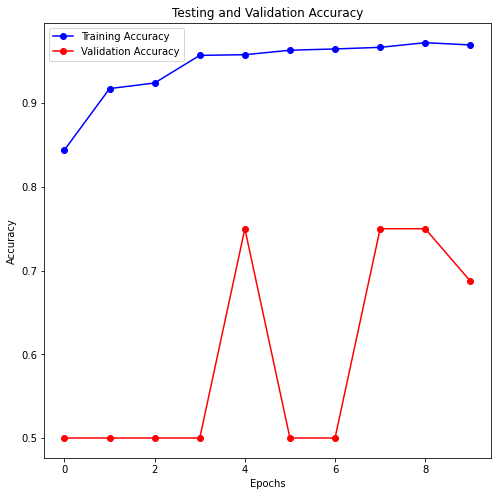

In [14]:
epochs = [i for i in range(10)]
plt.figure(figsize=(8,8))
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

plt.plot(epochs , train_acc , 'b-o' , label = 'Training Accuracy')
plt.plot(epochs , val_acc , 'r-o' , label = 'Validation Accuracy')
plt.title('Testing and Validation Accuracy')
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

# Metrics Evaluation

Let's start with the detailed classification report analysis!

![](https://memegenerator.net/img/instances/57284431/sent-out-daily-report-no-funny-picture.jpg)

In [15]:
predictions = model.predict(x_test)
predictions = predictions.reshape(1,-1)[0]
predictions[:30]

20/20 [==============================] - 4s 203ms/step


array([6.0894298e-03, 1.3265073e-05, 4.0010354e-18, 1.0322124e-29,
       1.1307018e-27, 7.0057820e-29, 3.5429176e-21, 2.4098497e-26,
       7.1701372e-01, 7.7713528e-25, 2.4283564e-30, 5.6396413e-05,
       2.1331155e-15, 1.6635288e-04, 7.9516165e-02, 3.1186703e-20,
       0.0000000e+00, 3.1927759e-03, 8.5645949e-04, 6.5493509e-06,
       1.4079061e-01, 1.0334833e-02, 4.2298402e-07, 4.3569286e-03,
       2.3798782e-03, 3.4466881e-04, 2.3452731e-11, 2.4668345e-21,
       8.1212259e-25, 1.2213614e-02], dtype=float32)

In [16]:
print(classification_report(y_test, predictions.round(), target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.89      0.97      0.93       390
   Normal (Class 1)       0.95      0.81      0.87       234

           accuracy                           0.91       624
          macro avg       0.92      0.89      0.90       624
       weighted avg       0.91      0.91      0.91       624



**Observation** The classification report is showing quite convinving values. In the next step, we will make a confusion matrix and take a look into how succesfully has our model been able to indicate the correct labels


<AxesSubplot:>

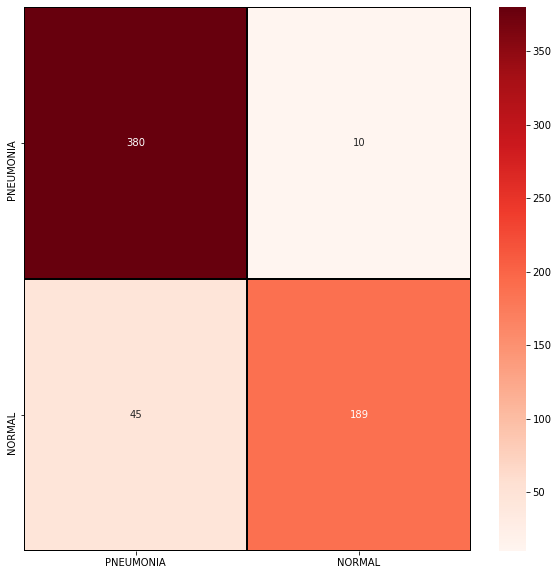

In [17]:
cm = confusion_matrix(y_test,predictions.round())
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

**Observation** Sufficiently good model! The 90%+ accuracy seems quite legit and satisfying. 

# Discussions

1. The data in the distribution seemed not well distributed. This had been a crucial part of the modelling activity where the data augmentation had become a crucial point. The augmentation too might need to be improvised in the future enahncements of this Notebook.
2. Need to check further into the model to understand if the neural network is already too complex and it is over fitting. Will get on it in the future enhancements of this notebook.
3. Juts two major metrics- Classification Report and Confusion Matrix has been provided. Will be looking forward to add newer metrics for better understanding the data

# Conclusion

1. The Accuracy level that we have reached at the very first attempt is good. However, we will need to spot the wastages and minimize the loss happening.
2. Further Data Augmentation needs to be done on the dataset.


